#### Regularización

La regularización consiste en una serie de métodos que buscan reducir el sobreajuste en modelos de Machine Learning y Estadística. En general la idea es sacrificar algo de la capacidad de predicción en el entrenamiento para aumentar la generalización del modelo (recordar el trade-off varianza-sesgo y la generalización). Voy a dar una idea general de regularización antes de introducir uno de los métodos particulares.

Supongamos que tenemos un dataset que consiste en 50 columnas y 70 filas como se muestra en la imagen a continuación. Si construímos un modelo de regresión lineal, ¿son esas 50 variables lo mejor para predecir la variable $y$? ¿Cómo podemos definir cuáles son relevantes y cuáles no?

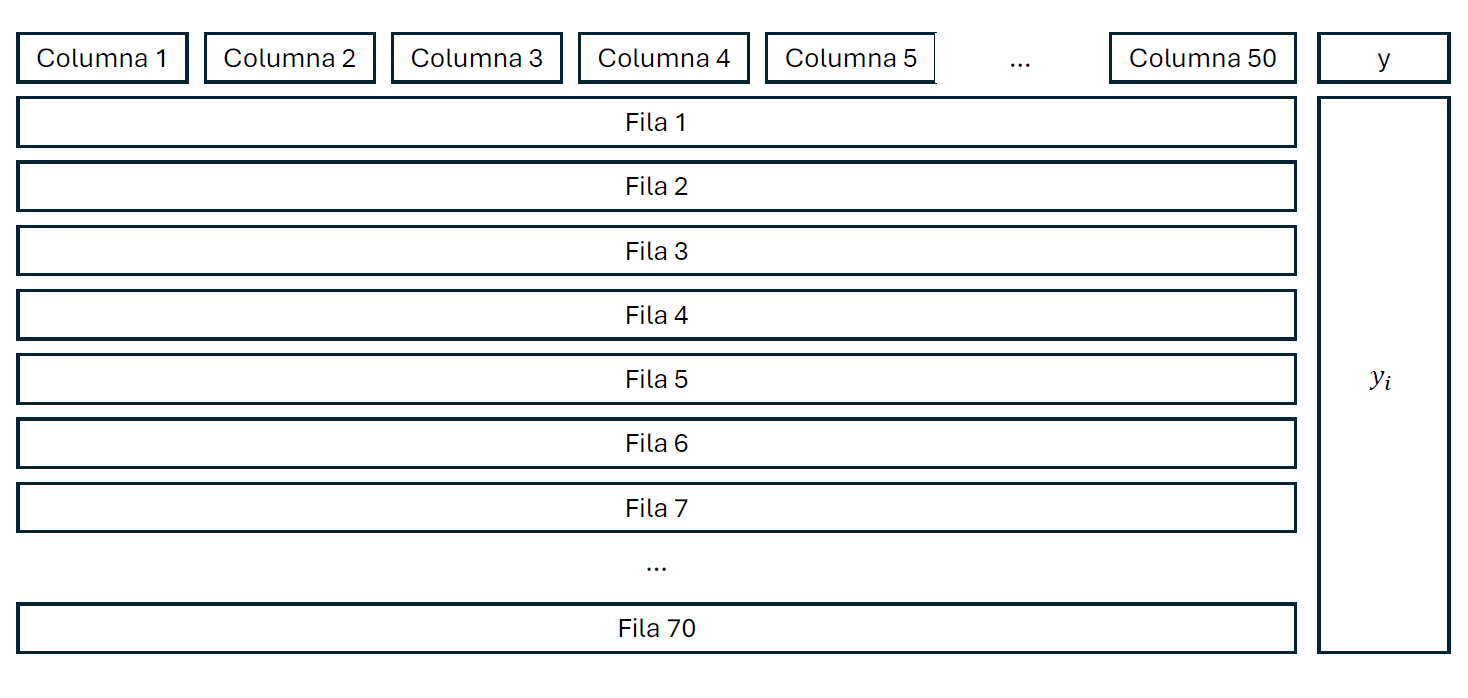

In [223]:
from IPython.display import Image
Image(filename=r'C:\Users\gonza\Desktop\Doctorado\Otros\Modelo Lasso\Lasso_df.png')

Para lidiar con lo anterior existen diversos métodos que simplifican un modelo, algunos populares y bastante sencillos de implementar son los algoritmos de selección de variable como "backward selection", "forward selection" y "stepwise selection", métodos en los que se prueba iterativamente agregando y/o sacando variables y probando el resultado acorde a algún criterio hasta que no hay mejora en el resultado.

Entre estos métodos surgen otros métodos derivados de OLS en modelos de regresión, me refiero a Ridge y Lasso. Durante este proyecto nos enfocaremos en el segundo como método de regularización. Se asume que el lector tiene conocimientos de métodos acerca de temas de regresión lineal y entiende los conceptos de generalización. Sean $\beta_{\lambda}^{{l}}$ los coeficientes de la regresión Lasso para un conjunto de datos $x_i\in \mathbb{R}^{p}$ e $y_i \in \mathbb{R}$, con $p$ el número de predictores (covariables) y $n$ el tamaño de la muestra (número de filas) que minimizan la siguiente expresión:

\begin{equation}
\beta_{\lambda}^{{l}} = \text{argmin}_{\beta_{\lambda}^{{l}}} \{ \sum_{i=1}^{n} (y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij})^2  + \lambda \sum_{j=1}^{p} |\beta_j| \}
\end{equation}

Equivalentemente podemos escribir,

\begin{equation}
\beta_{\lambda}^{{l}} = \text{argmin}_{\beta_{\lambda}^{{l}}} \{ \text{RSS} + \lambda \sum_{j=1}^{p} \beta_j \}
\end{equation}

Donde RSS representa la suma de los cuadrados de los residuos (Residuals Sum of Squares). Lo anterior se conoce como norma $l_1$, mientras que la regresión Ridge recibe el nombre de norma $l_2$. Una de las principales características de la regresión Lasso es que tiene la capacidad de dejar coeficientes de una regresión en cero, característica que la norma $l_2$ no posee (a menos que $\lambda \rightarrow \infty$). Otra característica interesante de estos métodos de regularización es que si $\lambda = 0$ la expresión de regularización se convierte en el método tradicional de OLS en regresión lineal.

Para implementar este modelo en un solver de optimización realizamos un ajuste sobre la función a minimizar para tratar el valor absoluto presente en esta. Así, podemos escribir la siguiente expresión.

\begin{equation}
\beta_{\lambda}^{{l}} = \text{argmin}_{\beta_{\lambda}^{{l}}} \{ \sum_{i=1}^{n} (y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij})^2  + \lambda \sum_{j=1}^{p} \alpha_j \}
\end{equation}

Sujeto a:

\begin{equation}
\alpha_j - \beta_j \geq 0, \forall j \in \{1,\dots,p\}
\end{equation}

\begin{equation}
\alpha_j + \beta_j \geq 0, \forall j \in \{1,\dots,p\}
\end{equation}

\begin{equation}
\lambda \geq 0
\end{equation}

Cargamos algunos paquetes necesarios para manejar datos, visualizar y modelar

In [5]:
import seaborn as sns
import numpy as np
from ucimlrepo import fetch_ucirepo 
import pandas as pd  
import matplotlib.pyplot as plt
import time
import statsmodels.api as sm
from gurobipy import *
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Primero definimos las funciones para encontrar los parámetros del modelo

In [52]:
class mse_gurobi():
    def __init__(self):
        self.data = df
    
    def model_optimization(lambda_lasso, target, X, y, df):
        
        y = np.array(y)
        lambda_lasso = lambda_lasso
        betas = {}
        beta_0 = 0
        alphas = {}
        
        quadratic_model = Model()

        for i in range(X.shape[1]):
            betas[i]  = quadratic_model.addVar(vtype = GRB.CONTINUOUS, name = 'beta_' + str(df.drop(target, axis = 1).columns[i]), lb = -GRB.INFINITY)
            alphas[i] = quadratic_model.addVar(vtype = GRB.CONTINUOUS, name = 'alpha' + str(df.drop(target, axis = 1).columns[i]), lb = -GRB.INFINITY)
        quadratic_model.update()

        beta_0 = quadratic_model.addVar(vtype = GRB.CONTINUOUS, name = 'beta_0', lb = -GRB.INFINITY)
        quadratic_model.update()

        obj_fn = sum((y[i] - (beta_0 + sum(betas[j] * X[i][j] for j in range(X.shape[1]))))**2 + lambda_lasso*sum(alphas[k] for k in range(X.shape[1])) for i in range(X.shape[0]))

        quadratic_model.setObjective(obj_fn, GRB.MINIMIZE)
        quadratic_model.update()

        for i in range(X.shape[1]):
            quadratic_model.addConstr(alphas[i] - betas[i] >= 0)
            quadratic_model.addConstr(alphas[i] + betas[i] >= 0)

        quadratic_model.update()

        quadratic_model.setParam('OutputFlag', False)
        quadratic_model.setParam('MIPGap', 0.01)

        start = time.time()
        quadratic_model.optimize()
        done = time.time()

        elapsed = ['Time', done - start]

        values_betas = []
        for i in range(len(betas)):
            if np.abs(betas[i].x) <= 0.001:
                values_betas.append(0)
            else:
                values_betas.append(betas[i].x)
        
        return beta_0.x, values_betas

Y otra función para calcular el desempeño del modelo

In [75]:
def performance_regression(slope, parameters, X, y):
    
    y = np.array(y)
    
    SStot = sum((y[i] - np.mean(y))**2 for i in range(X.shape[0]))
    
    fitted_values = []
    
    for i in range(X.shape[0]):
        fitted_values.append(beta_0 + sum(values_betas[j] * X[i][j] for j in range(X.shape[1])))
    
    SSres = sum((y[i] - fitted_values[i])**2 for i in range(X.shape[0]))
    R2_score = (1 - SSres / SStot)
    
    return R2_score, fitted_values

La simulación de datos para el modelo se realiza utilizando la función "make_regression" de "sklearn" la cual hace uso de combinaciones lineales de características aleatorias considerando un ruido definido por el usuario de la siguiente forma.

\begin{equation}
y_i = \beta_0 + \sum_{j=1}^{p} \beta_i x_{ij} + \epsilon_{ij}, \forall i \in \{1, \dots, n\}
\end{equation}

Donde $p$ corresponde a la cantidad de covariables definidos por el usuario, $n$ el tamaño de muestra también definido, y $\epsilon_{ij}$ el ruido aleatorio fijado en la función. Para un ejemplo práctico del método vamos a simular datos de 100 filas y 10 columnas con poco ruido

In [54]:
from sklearn.datasets import make_regression

X, y = make_regression(n_samples = 100,
                       n_features = 10,
                       noise = 2,
                       random_state = 1234)

Podemos revisar las correlaciones generadas en la simulación

<Axes: >

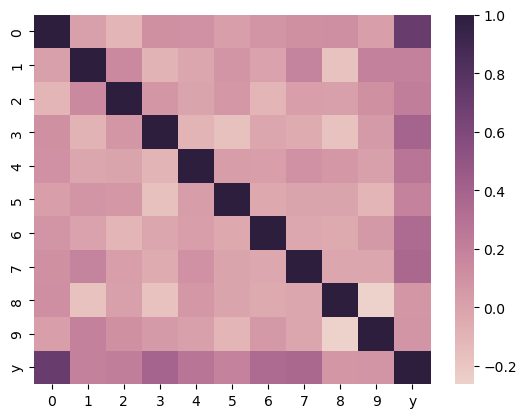

In [55]:
import seaborn as sns

df = pd.concat([pd.DataFrame(X), pd.DataFrame(y, columns=['y'])], axis = 1)
corr = df.corr()
sns.heatmap(corr, annot=False, cmap=sns.cubehelix_palette(as_cmap=True))

Primero revisemos que al hacer $\lambda = 0$ el modelo Lasso es equivalente al modelo OLS. A continuación revisamos una salida de una regresión por OLS tradicional a través de "statmodels"

In [56]:
X_ols = sm.add_constant(X)
model = sm.OLS(y, X_ols)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.451e+04
Date:                Sun, 17 Nov 2024   Prob (F-statistic):          5.50e-170
Time:                        12:30:41   Log-Likelihood:                -198.07
No. Observations:                 100   AIC:                             418.1
Df Residuals:                      89   BIC:                             446.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1978      0.196     -1.007      0.3

Probemos el modelo Lasso dejando el parámetro $\lambda = 0$

In [57]:
beta_0, values_betas = mse_gurobi.model_optimization(lambda_lasso = 0, target = 'y', X = X, y = y, df = df)

Si revisamos los resultados notamos que ambos son iguales (con algunas diferencias en los decimales dada la aproximación)

In [58]:
results.params

array([-0.19782395, 92.36542442, 25.34365871, 39.81013729, 72.07331008,
       39.67051946, 37.31086249, 50.64317046, 47.27352137, 18.37034091,
        6.16168916])

In [59]:
print(beta_0)
print(values_betas)

-0.1978239535689989
[92.36542441945689, 25.343658713407525, 39.81013729104164, 72.07331007681256, 39.67051946159364, 37.31086248975726, 50.64317045867158, 47.27352137012737, 18.370340914349462, 6.1616891611796705]


#### Modelo Lasso

Ahora apliquemos el modelo lasso sobre un conjunto de datos real. Para esto utilizamos el conjunto de datos "hitters" (mayor información en https://rdrr.io/cran/ISLR/man/Hitters.html)

In [112]:
import os
os.chdir(r'C:\Users\gonza\Desktop\Hitters')
os.listdir()

['Hitters.csv']

Cargamos los datos, eliminamos valores nulos (el foco no está en trabajar en imputación o ajustes de ese estilo) y seleccionamos solo las variables numéricas.

In [194]:
df = pd.read_csv('Hitters.csv')
df.dropna(inplace = True)
df.reset_index(inplace = True)
df = df.select_dtypes(['int64', 'float64'])

Nuestra variable objetivo es el salario (Salary), realizamos un escalamiento de las variables necesario durante este tipo de procedimientos de regularización y separamos en entrenamientos de entrenamiento y testeo.

In [195]:
df = df.drop('index', axis = 1)

In [196]:
df.head(5)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
0,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0
1,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0
2,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0
3,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5
4,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0


In [197]:
y = df['Salary']
X = df.drop('Salary', axis = 1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1234)

Corremos una grilla de 50 posibles valores de $\lambda$ entre 0 y 10. Para cada iteración guardamos el valor del error cuadrático medio (MSE) y el valor del $R^2$ en el entrenamiento

In [198]:
lambdas_values = np.linspace(0, 10, 50)
mses = []
maes = []
r2_scores_train = []
for i in lambdas_values:
    
    beta_0, values_betas = mse_gurobi.model_optimization(lambda_lasso=i,
                                                         target = 'Salary',
                                                         X = X_train, 
                                                         y = y_train, 
                                                         df = df)
    
    r2_score_model, fitted = performance_regression(slope = beta_0,
                                                    parameters = values_betas, 
                                                    X = X_train, 
                                                    y = y_train)

    y_pred = []
    for l in range(X_test.shape[0]):
        y_pred.append(beta_0 + sum(values_betas[m] * X_test[l][m] for m in range(X_test.shape[1])))
    r2_scores_train.append(r2_score_model)
    mses.append(mean_squared_error(y_test, y_pred))
    maes.append(mean_absolute_error(y_test, y_pred))

Notar como a medida que aumenta el valor del parámetro $\lambda$ el rendimiento del modelo en el testeo aumenta (menor error cuadrático medio en el eje Y) hasta llegar a un valor donde el error comienza a aumentar.

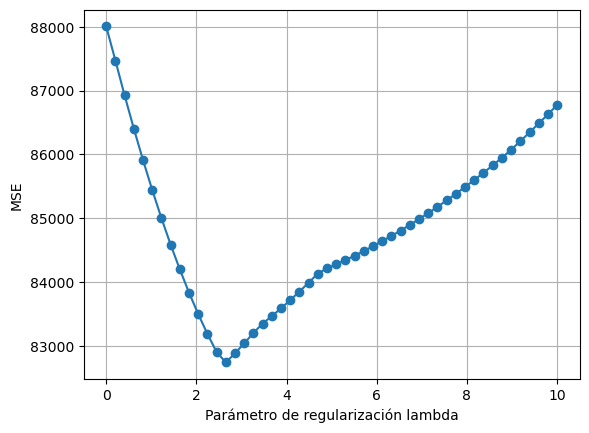

In [199]:
plt.plot(lambdas_values, mses, marker = 'o')
plt.grid(True)
plt.xlabel("Parámetro de regularización lambda")
plt.ylabel("MSE")
plt.show()

Podemos hacer lo mismo comparando el valor del $R^2$ en el entrenamiento y el valor del MSE.

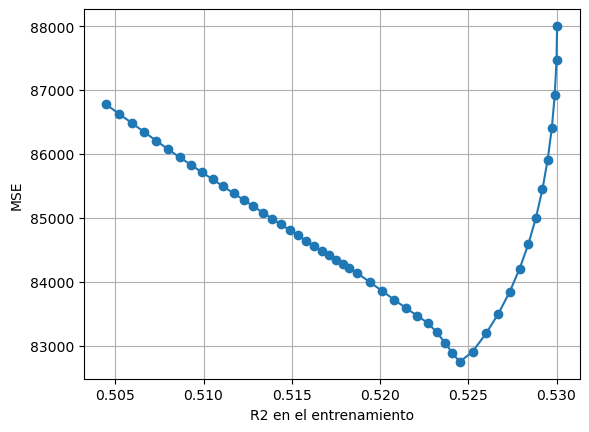

In [200]:
plt.plot(r2_scores_train, mses, marker = 'o')
plt.xlabel("R2 en el entrenamiento")
plt.ylabel("MSE")
plt.grid(True)
plt.show()

Podemos generar una gráfica 3D con las tres variables anteriores

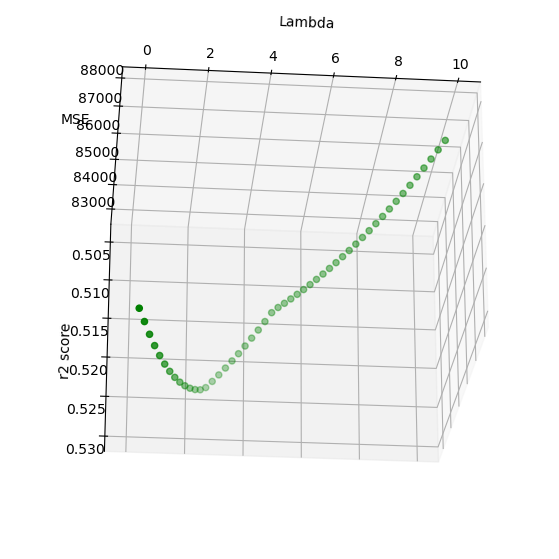

In [201]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.view_init(azim=275, elev=155) # Cambiando estos valores cambia la visualización
ax.set_xlabel('Lambda')
ax.set_ylabel('MSE')
ax.set_zlabel('r2 score')
ax.scatter3D(lambdas_values, mses, r2_scores_train, color = "green")

Podemos obtener el valor de lambda que minimiza el error cuadrático medio y hacer la regresión con este valor

In [202]:
optimal_lambda = lambdas_values[np.argmin(mses)]
print(optimal_lambda)

2.6530612244897958


In [203]:
beta_0, values_betas = mse_gurobi.model_optimization(lambda_lasso=3, # solo por aproximar
                                                     target = 'Salary',
                                                     X = X_train,
                                                     y = y_train,
                                                     df = df)

Notar que el modelo deja tres variables en cero, estas son "Runs", "CHits" y "CHmRun". Cada valor lo revisamos a continuación

In [215]:
pd.DataFrame({'Variable': df.drop('Salary', axis = 1).columns,'Valor': values_betas})

,Variable,Valor
0,AtBat,-302.899340
1,Hits,296.620926
2,HmRun,5.232718
3,Runs,0.000000
4,RBI,11.426739
5,Walks,88.002126
6,Years,-73.189409
7,CAtBat,-111.852847
8,CHits,0.000000
9,CHmRun,0.000000


Con lo anterior dejamos un modelo con 13 variables en lugar de 16. Si bien este ejercicio práctico no es tan drástico, puede haber casos en que la regularización simplifica modelos que a priori son mucho más complejos. Otros puntos no mencionados en este apartado son los efectos que tiene la colinealidad sobre la regresión Lasso, un punto no menor para ambos métodos de regularización.